# Chapter 9 - Tax-Efficient Withdrawal Strategies

## Listing 9.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rates = [0.1, 0.12, 0.22, 0.24, 0.32, 0.35, 0.37]
top_of_bracket = [11000, 44725, 95375, 182100, 231250, 578125, np.inf]
TaxTable = pd.DataFrame({'rate': rates,
                         'top_of_bracket': top_of_bracket,})
TaxTable

,rate,top_of_bracket
0,0.10,11000.0
1,0.12,44725.0
2,0.22,95375.0
3,0.24,182100.0
4,0.32,231250.0
5,0.35,578125.0
6,0.37,inf


## Listing 9.2

In [2]:
def calc_taxes(income, TaxTable, deduction):
    taxable_income = income - deduction
    i = 0
    tax = 0
    bottom = 0
    while taxable_income > bottom:
        bracket_income = min(TaxTable.iloc[i]['top_of_bracket'],
                             taxable_income) - bottom
        tax += TaxTable.iloc[i]['rate'] * bracket_income
        bottom = TaxTable.iloc[i]['top_of_bracket']
        i += 1
    return tax

In [3]:
calc_taxes(120000, TaxTable, 13850)

np.float64(18876.0)

## Listing 9.3

In [4]:
from scipy.optimize import fsolve

def gross_up(gross, net, TaxTable, deduction):
    tax = calc_taxes(gross, TaxTable, deduction)
    return gross - tax - net

root = fsolve(gross_up, 0, args=(120000, TaxTable, 13850))
print('The pre-tax withdrawal amount is ', root.item())

The pre-tax withdrawal amount is  144836.84210526315


## Listing 9.4

In [ ]:
ret = {'taxable':0.03, 'IRA':0.04, 'Roth':0.04}
starting_values = {'taxable':2000000, 'IRA':1000000, 'Roth':0}
spending = 120000
deduction = 13850
max_years = 55

def compute_years(order,
                  ret, starting_values, max_years,
                  spending, deduction, TaxTable):
    df = pd.DataFrame(0., columns=['taxable', 'IRA', 'Roth'],
                      index = range(max_years+1)) #A
    df.iloc[0] = starting_values
    i = 0
    while (df.iloc[i].sum() - calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction)
           > spending) and i < max_years:
        spending_left = spending
        for acct_type in order:
            if acct_type != 'IRA':
                withdraw = min(df.iloc[i][acct_type], spending_left)
                spending_left -= withdraw
            else: #B
                withdraw = min(df.iloc[i][acct_type],
                               fsolve(gross_up, spending_left,
                               args=(spending_left, TaxTable, deduction)))
                spending_left -= (withdraw -
                                  calc_taxes(withdraw,TaxTable,deduction))
            df.iloc[i+1][acct_type] = ((df.iloc[i][acct_type] - withdraw) *
                                       (1+ret[acct_type]))
        i = i + 1
    frac = (df.iloc[i].sum() -
            calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction))/spending
    print(i+frac)
    return df


#A DataFrame that keeps track of assets in each account type by year
#B For an  IRA, gross up the amount of money needed for spending

## Strategy 1

In [ ]:
order = ['IRA', 'taxable', 'Roth']
df = compute_years(order,
                   ret, starting_values, max_years,
                   spending, deduction, TaxTable)

39.977228753630875


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/2068923953.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i+1][acct_type] = ((df.iloc[i][acct_type] - withdraw) *


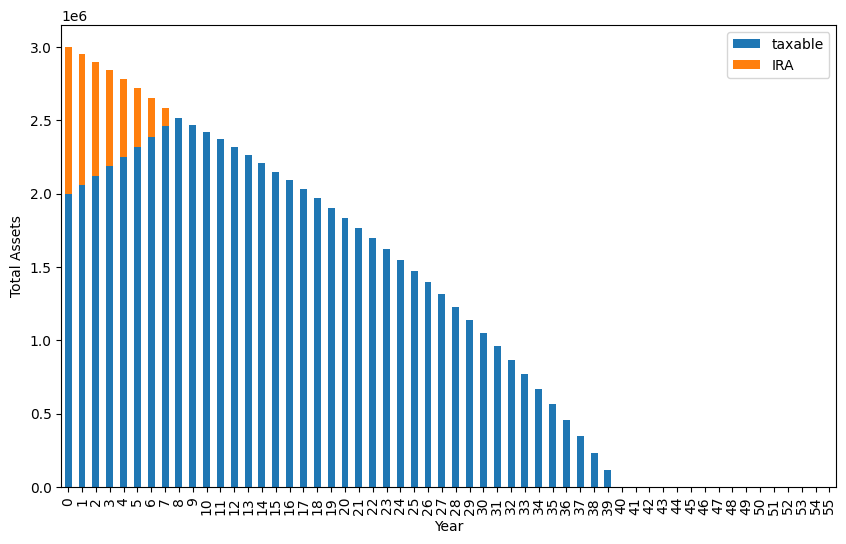

In [ ]:
all_types = ['taxable','Roth','IRA']
cols_plot = ['taxable','Roth','IRA']
for type in all_types:
    all_zeros = np.all(df[type]==0)
    if all_zeros:
        cols_plot.remove(type)
ax = df.loc[:,cols_plot].plot(kind='bar',stacked=True, figsize=(10,6))
ax.set_ylabel('Total Assets')
ax.set_xlabel('Year');

## Strategy 2

In [ ]:
order = ['taxable', 'IRA', 'Roth']
df = compute_years(order,
                   ret, starting_values, max_years,
                   spending, deduction, TaxTable)

48.74069668982323


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/2068923953.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i+1][acct_type] = ((df.iloc[i][acct_type] - withdraw) *


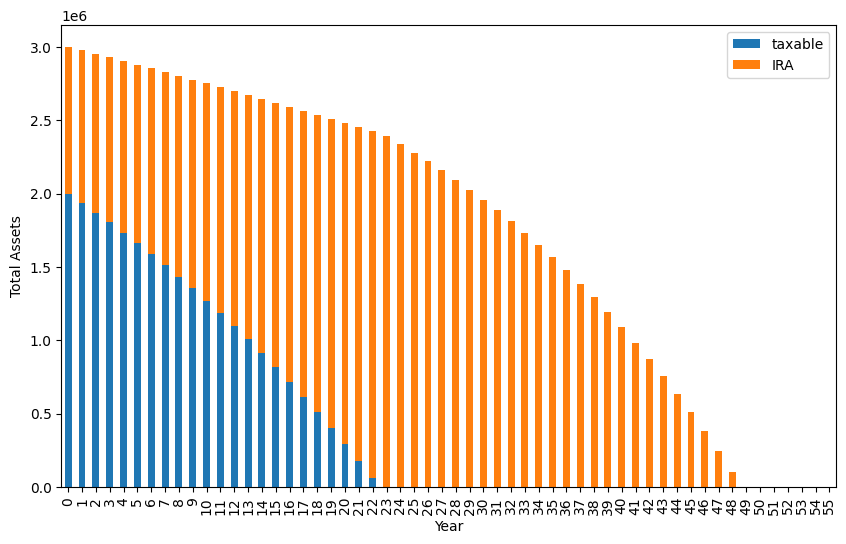

In [ ]:
all_types = ['taxable','Roth','IRA']
cols_plot = ['taxable','Roth','IRA']
for type in all_types:
    all_zeros = np.all(df[type]==0)
    if all_zeros:
        cols_plot.remove(type)
ax = df.loc[:,cols_plot].plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Total Assets')
ax.set_xlabel('Year');

## Listing 9.5

In [ ]:
def compute_years_new(order, IRA_fill_amt, conversion_flag,
                      ret, starting_values, max_years,
                      spending, deduction, TaxTable):
    df = pd.DataFrame(0., columns=['taxable', 'IRA', 'Roth'],
                      index = range(max_years+1)) #A
    df.iloc[0] = starting_values
    i = 0
    while (df.iloc[i].sum() - calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction)
           > spending) and i < max_years:
        spending_left = spending

        #Take out of IRA first up to IRA_fill_amt
        if df.iloc[i]['taxable'] > spending:
            withdraw = min(df.iloc[i]['IRA'], IRA_fill_amt)
            if conversion_flag == 0:
                spending_left -= (withdraw -
                                  calc_taxes(withdraw,TaxTable,deduction))
                df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-withdraw) #A
            else:
                df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-withdraw)
                df.iloc[i]['Roth'] += (withdraw - #B
                                       calc_taxes(withdraw,TaxTable,deduction))
        for acct_type in order:
            if acct_type != 'IRA':
                withdraw = min(df.iloc[i][acct_type], spending_left)
                spending_left = spending_left - withdraw
            else:
                withdraw = min(df.iloc[i][acct_type],
                               fsolve(gross_up, spending_left,
                               args=(spending_left, TaxTable, deduction)))
                spending_left -= (withdraw -
                                  calc_taxes(withdraw,TaxTable,deduction))
            df.iloc[i+1][acct_type] = ((df.iloc[i][acct_type] - withdraw) *
                                       (1+ret[acct_type])  )
        i = i + 1
    frac = (df.iloc[i].sum() -
            calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction))/spending
    print(i+frac)
    return df


#A If no conversion, withdraw from the IRA account first
#B If conversion, withdraw from the IRA account and place the net amount, after taxes, into the Roth

## Strategy 3

In [ ]:
order = ['taxable', 'IRA', 'Roth']
IRA_fill_amt = 58575
conversion_flag = 0
df = compute_years_new(order, IRA_fill_amt, conversion_flag,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

44.53426311493234


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/537442662.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-withdraw) #A
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25

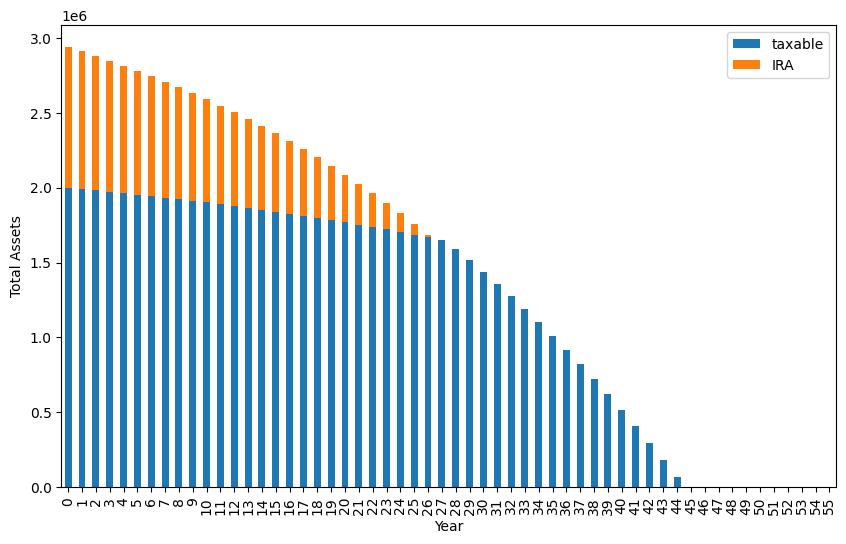

In [ ]:
all_types = ['taxable','Roth','IRA']
cols_plot = ['taxable','Roth','IRA']
for type in all_types:
    all_zeros = np.all(df[type]==0)
    if all_zeros:
        cols_plot.remove(type)
ax = df.loc[:,cols_plot].plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Total Assets')
ax.set_xlabel('Year');

## Strategy 4

In [ ]:
order = ['taxable', 'IRA', 'Roth']
IRA_fill_amt = 58575
conversion_flag = 1
df = compute_years_new(order, IRA_fill_amt, conversion_flag,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

53.24371366143054


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/537442662.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-withdraw)
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496

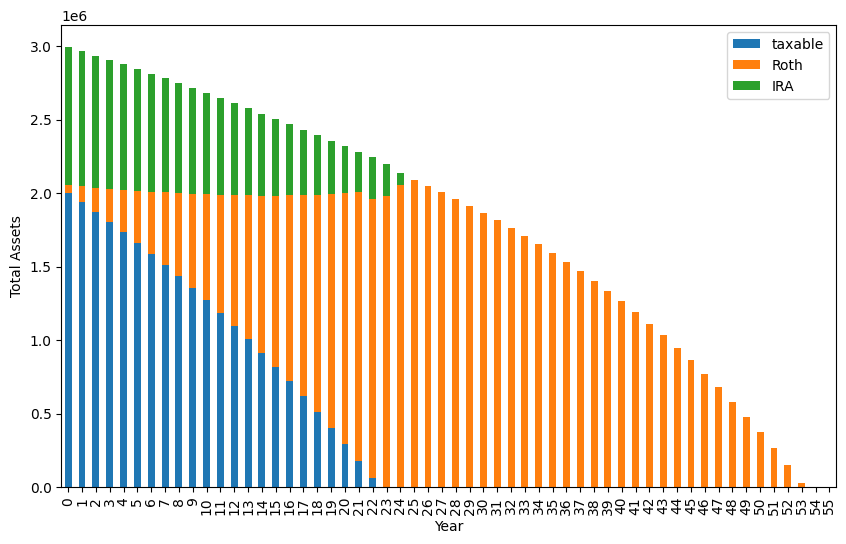

In [ ]:
all_types = ['taxable','Roth','IRA']
cols_plot = ['taxable','Roth','IRA']
for type in all_types:
    all_zeros = np.all(df[type]==0)
    if all_zeros:
        cols_plot.remove(type)
ax = df.loc[:,cols_plot].plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Total Assets')
ax.set_xlabel('Year');

## RMD Code

First, we scrape the Required Minimum Distribution table from the IRS website.

In [15]:
import requests
from bs4 import BeautifulSoup

URL = "https://www.irs.gov/publications/p590b"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

In [ ]:
# Insert picture of html from inspect

In [16]:
target_table = soup.find('table', {'summary': 'Appendix B. Uniform Lifetime Table'})
if target_table:
    rows = target_table.find_all('tr')
    for row in rows:
        columns = row.find_all('td')
        for column in columns:
            print(column.text)  # or any other processing you need
else:
    print("Table not found!")

 
 
 
 
 Table III 
 (Uniform Lifetime) 
 (For Use by:   Unmarried Owners,   Married Owners Whose Spouses Aren't More Than 10 Years Younger, and   Married Owners Whose Spouses Aren't the Sole Beneficiaries of Their IRAs)     
 Age 
 Distribution Period 
 Age 
 Distribution Period 
72
27.4
97
7.8
73
26.5
98
7.3
74
25.5
99
6.8
75
24.6
100
6.4
76
23.7
101
6.0
77
22.9
102
5.6
78
22.0
103
5.2
79
21.1
104
4.9
80
20.2
105
4.6
81
19.4
106
4.3
82
18.5
107
4.1
83
17.7
108
3.9
84
16.8
109
3.7
85
16.0
110
3.5
86
15.2
111
3.4
87
14.4
112
3.3
88
13.7
113
3.1
89
12.9
114
3.0
90
12.2
115
2.9
91
11.5
116
2.8
92
10.8
117
2.7
93
10.1
118
2.5
94
9.5
119
2.3
95
8.9
120 and over
2.0
96
8.4
 
 


In [17]:
if target_table:
    all_rows = target_table.find_all('tr')
else:
    print("Table not found!")

all_rows = [row.text.split() for row in all_rows]
RMD_div = {}
for row in all_rows[5:-2]:
    RMD_div[int(row[0])] = float(row[1])
    RMD_div[int(row[2])] = float(row[3])
for row in all_rows[-2:]:
    RMD_div[int(row[0])] = float(row[1])

In [18]:
def calc_RMD(age):
    if age <= 72:
        return 0
    elif age>= 120:
        return 0.5
    else:
        return 1./RMD_div[age]

In [19]:
calc_RMD(73)

0.03773584905660377

Note that now, `age` is an argument. We have ignored the increase in the standard deduction for seniors aged 65 and older. This could easily be added to the code if the standard deduction is taken.

In [ ]:
# Code for RMD

def gross_up_incremental(gross, net, TaxTable, deduction, prior_income):
    tax = calc_taxes(gross+prior_income, TaxTable, deduction) - calc_taxes(prior_income, TaxTable, deduction)
    return gross - tax - net

def compute_years_RMD(order, IRA_fill_amt, conversion_flag, age,
                      ret, starting_values, max_years,
                      spending, deduction, TaxTable):
    df = pd.DataFrame(0., columns=['taxable', 'IRA', 'Roth'], index = range(max_years+1))
    df.iloc[0] = starting_values
    i = 0
    while (df.iloc[i].sum() - calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction) > spending) and i<max_years:
        i = i + 1
        df.iloc[i] = df.iloc[i-1]
        spending_left = spending

        RMD = df.iloc[i]['IRA'] * calc_RMD(age+i)
        if df.iloc[i]['taxable']>spending:
            IRA_fill = min(df.iloc[i]['IRA'], IRA_fill_amt)
        else:
            IRA_fill = 0
        IRA_withdraw = max(RMD, IRA_fill)
        if conversion_flag == 0:
            spending_left = spending_left - (IRA_withdraw - calc_taxes(IRA_withdraw,TaxTable,deduction))
            df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
        else:
            df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
            df.iloc[i]['Roth'] = (df.iloc[i]['Roth']+(IRA_withdraw-RMD)-calc_taxes(IRA_withdraw-RMD,TaxTable,deduction))
            spending_left -= RMD - calc_taxes(IRA_withdraw,TaxTable,deduction) + calc_taxes(IRA_withdraw-RMD,TaxTable,deduction)
        for acct_type in order:
            if acct_type != 'IRA':
                withdraw = min(df.iloc[i][acct_type], spending_left)
                spending_left = spending_left - withdraw
            else:
                withdraw = min(df.iloc[i][acct_type], fsolve(gross_up_incremental, spending_left,
                                           args=(spending_left, TaxTable, deduction, IRA_withdraw)))
                spending_left -= (withdraw -calc_taxes(withdraw+IRA_withdraw,TaxTable,deduction)+calc_taxes(IRA_withdraw,TaxTable,deduction))
            df.iloc[i][acct_type] = (df.iloc[i][acct_type]-withdraw)*(1+ret[acct_type])
    frac = (df.iloc[i].sum()-calc_taxes(df.iloc[i]['IRA'],TaxTable,deduction))/spending
    print(i+frac)
    return df

## Table 9.6

In [ ]:
order = ['IRA', 'taxable', 'Roth']
IRA_fill_amt = 0
conversion_flag = 0
age = 65

df = compute_years_RMD(order, IRA_fill_amt, conversion_flag, age,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

39.977228753630875


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/1036975467.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_

In [ ]:
order = ['taxable', 'IRA', 'Roth']
IRA_fill_amt = 0
conversion_flag = 0
age = 65

df = compute_years_RMD(order, IRA_fill_amt, conversion_flag, age,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

47.30193598560664


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/1036975467.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_

In [ ]:
order = ['taxable', 'IRA', 'Roth']
IRA_fill_amt = 58575
conversion_flag = 0
age = 65

df = compute_years_RMD(order, IRA_fill_amt, conversion_flag, age,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

44.53426311493234


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/1036975467.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_

In [ ]:
order = ['taxable', 'IRA', 'Roth']
IRA_fill_amt = 58575
conversion_flag = 1
age = 65

df = compute_years_RMD(order, IRA_fill_amt, conversion_flag, age,
                       ret, starting_values, max_years,
                       spending, deduction, TaxTable)

52.14112153261502


/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_25496/1036975467.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.iloc[i]['IRA'] = (df.iloc[i]['IRA']-IRA_withdraw)
/var/folders/6g/0ggzchw54n9_f4jpxx_2www80000gp/T/ipykernel_

In [ ]:
def calc_taxes(income, TaxTable, deduction, State_TaxTable,
               state_deduction, LTCG_TaxTable, ST_gains, LT_gains, t):

    # State Taxes
    taxable_income = (income - state_deduction * (1+infl)**t
                      + ST_gains + LT_gains)
    i = 0
    tax = 0
    bottom = 0
    while taxable_income > bottom:
        bracket_income = min(State_TaxTable.iloc[i]['top_of_bracket'] *
                             (1+infl)**t, taxable_income) - bottom
        tax += State_TaxTable.iloc[i]['rate']*bracket_income
        bottom = State_TaxTable.iloc[i]['top_of_bracket'] * (1+infl)**t
        i += 1

    # Federal Taxes
    taxable_income = income - deduction*(1+infl)**t + ST_gains
    i = 0
    bottom = 0
    while taxable_income > bottom:
        bracket_income = min(TaxTable.iloc[i]['top_of_bracket'] *
                             (1+infl)**t, taxable_income) - bottom
        tax += TaxTable.iloc[i]['rate']*bracket_income
        bottom = TaxTable.iloc[i]['top_of_bracket']*(1+infl)**t
        i += 1

    # Capital Gains Taxes
    i = (LTCG_TaxTable['top_of_bracket'] *
         (1+infl)**t).searchsorted(taxable_income).item() #A
    bottom = taxable_income
    while taxable_income + LT_gains > bottom:
        bracket_income = min(LTCG_TaxTable.iloc[i]['top_of_bracket'] *
                             (1+infl)**t,taxable_income+LT_gains) - bottom
        tax += LTCG_TaxTable.iloc[i]['rate'] * bracket_income
        bottom = LTCG_TaxTable.iloc[i]['top_of_bracket'] * (1+infl)**t
        i += 1

    # Medicare surtax
    NIIT = min(max(income+ST_gains+LT_gains-200000,0), LT_gains) * 0.038
    tax = tax + NIIT
    return tax